In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
import scipy.stats as stats

In [2]:
# Assuming you have the CSV files in the same directory as this Python script
transaction_data = pd.read_csv("transaction_data.csv")
customer_data = pd.read_csv("purchase.csv") 

In [3]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [5]:
print(transaction_data.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
None


In [6]:
# Assuming the 'DATE' column is an integer representing days since epoch (1899-12-30)
def convert_date_to_datetime(date_value):
  return datetime.date(year=1899, month=12, day=30) + datetime.timedelta(days=date_value)

transaction_data['DATE'] = transaction_data['DATE'].apply(convert_date_to_datetime)

# Alternatively, if 'DATE' is a string in YYYYMMDD format
# transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], format='%Y%m%d')

In [7]:
# Summary of PROD_NAME
print(transaction_data['PROD_NAME'].value_counts())

PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
                                            ... 
RRD Pc Sea Salt     165g                    1431
Woolworths Medium   Salsa 300g              1430
NCC Sour Cream &    Garden Chives 175g      1419
French Fries Potato Chips 175g              1418
WW Crinkle Cut      Original 175g           1410
Name: count, Length: 114, dtype: int64


In [8]:
# Extract unique product names
unique_prod_names = transaction_data['PROD_NAME'].unique()

In [9]:
# Split each product name into individual words
words = []
for name in unique_prod_names:
    words.extend(name.split(' '))

In [10]:
# Create a DataFrame with the extracted words
product_words = pd.DataFrame({'words': words})
print(product_words)

       words
0    Natural
1       Chip
2           
3           
4           
..       ...
818  Doritos
819    Salsa
820     Mild
821         
822     300g

[823 rows x 1 columns]


In [11]:
# --- Removing digits and special characters ---
# Extract unique product names
unique_prod_names = transaction_data['PROD_NAME'].unique()

In [12]:
# Split each product name into individual words
words = []
for name in unique_prod_names:
    words.extend(name.split(' '))

In [13]:
# Remove digits and special characters from words
clean_words = [re.sub(r'[0-9]', '', word) for word in words] 
clean_words = [re.sub(r'[^a-zA-Z\s]', '', word) for word in clean_words] 

In [14]:
# Create a DataFrame with the cleaned words
product_words = pd.DataFrame({'words': clean_words})

In [15]:
# --- Remove salsa products ---
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.contains('salsa')
transaction_data = transaction_data[~transaction_data['SALSA']]
transaction_data = transaction_data.drop(columns=['SALSA'])

In [16]:
# --- Initial summary ---
print(transaction_data.describe()) 

           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  246742.000000    2.467420e+05  2.467420e+05  246742.000000   
mean      135.051098    1.355310e+05  1.351311e+05      56.351789   
std        76.787096    8.071528e+04  7.814772e+04      33.695428   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.001500e+04  6.756925e+04      26.000000   
50%       130.000000    1.303670e+05  1.351830e+05      53.000000   
75%       203.000000    2.030840e+05  2.026538e+05      87.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246742.000000  246742.000000  
mean        1.908062       7.321322  
std         0.659831       3.077828  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.000000       8.800000  
max       200.000000     650.000000  


In [17]:
# --- Investigate outlier (quantity = 200) ---
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] == 200]
print(outlier_transactions)

             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762  2018-08-19        226          226000  226201         4   
69763  2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


In [18]:
# --- Examine other transactions of the outlier customer ---
outlier_customer_id = outlier_transactions['LYLTY_CARD_NBR'].unique()[0] 
customer_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == outlier_customer_id]
print(customer_transactions)

             DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762  2018-08-19        226          226000  226201         4   
69763  2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


In [19]:
# --- Filter out the outlier customer ---
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outlier_customer_id]

In [20]:
# --- Count the number of transactions by date ---

transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'])
transactions_by_day = transaction_data.groupby('DATE')['LYLTY_CARD_NBR'].count().reset_index(name='N')

In [21]:
# --- Create a sequence of dates ---
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')
all_dates = pd.DataFrame({'DATE': date_range})

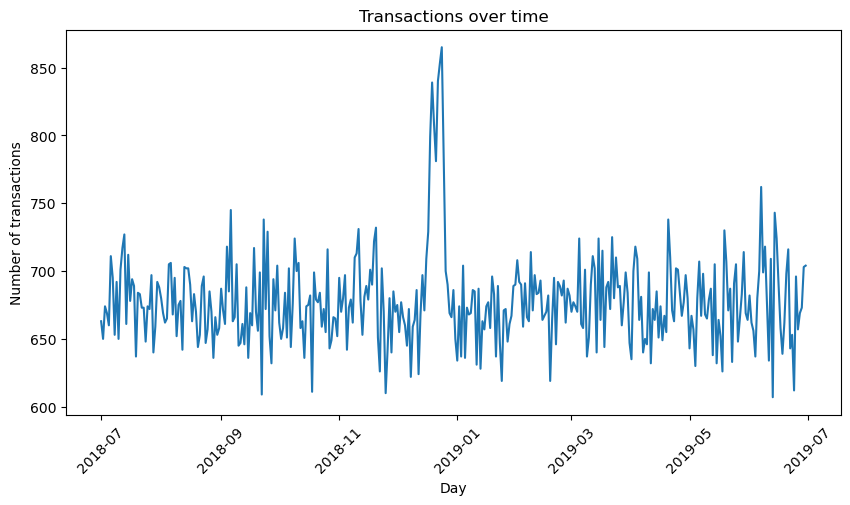

In [22]:
# --- Plot transactions over time ---

plt.figure(figsize=(10, 5))
sns.lineplot(x='DATE', y='N', data=transactions_by_day)
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.show()


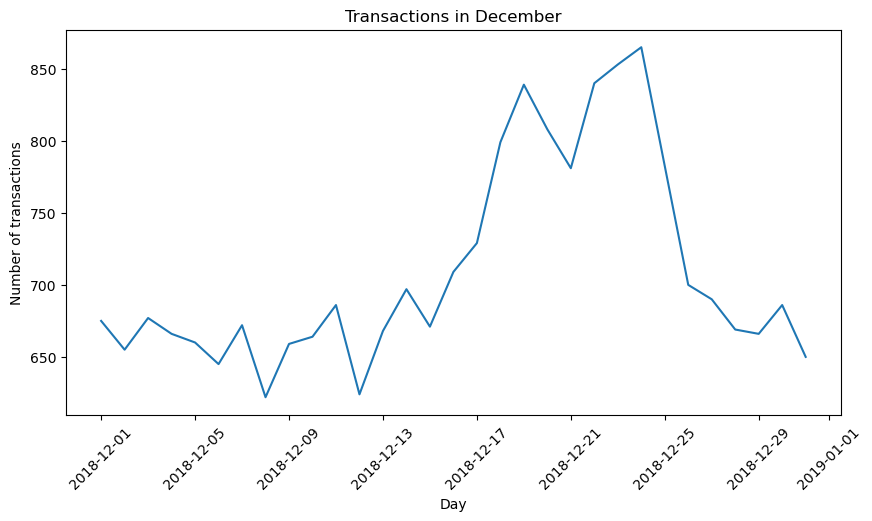

In [23]:
# --- Zoom in on December ---

december_data = transactions_by_day[(transactions_by_day['DATE'] >= '2018-12-01') & (transactions_by_day['DATE'] <= '2018-12-31')]

plt.figure(figsize=(10, 5))
sns.lineplot(x='DATE', y='N', data=december_data)
plt.title('Transactions in December')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.show()

In [24]:
# Extract pack size from PROD_NAME
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)g') 
transaction_data['PACK_SIZE'] = pd.to_numeric(transaction_data['PACK_SIZE'])

In [25]:
# Check for sensible pack sizes
print(transaction_data.groupby('PACK_SIZE').size().sort_index()) 

PACK_SIZE
70.0      1507
90.0      3008
110.0    22387
125.0     1454
134.0    25102
135.0     3257
150.0    38705
160.0     2970
165.0    15297
170.0    19983
175.0    64929
180.0     1468
190.0     2995
200.0     4473
210.0     3167
220.0     1564
250.0     3169
270.0     6285
330.0    12540
380.0     6416
dtype: int64


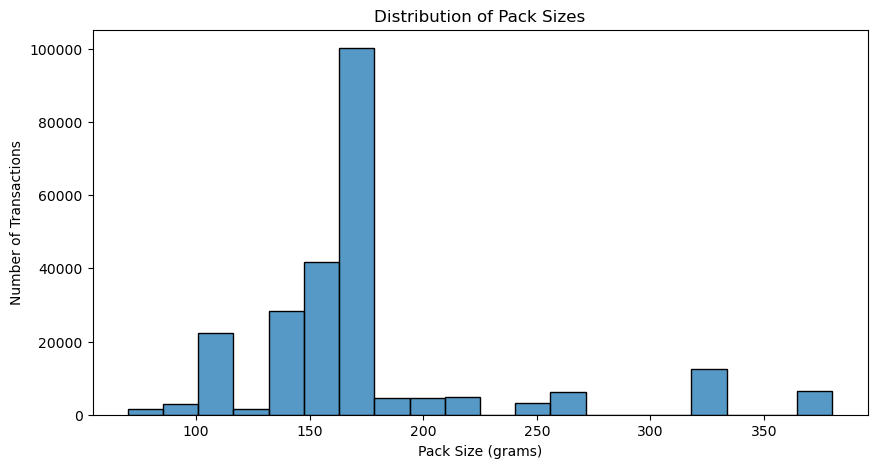

In [26]:
# --- Plot a histogram of PACK_SIZE ---
plt.figure(figsize=(10, 5))
sns.histplot(data=transaction_data, x='PACK_SIZE', bins=20) 
plt.title('Distribution of Pack Sizes')
plt.xlabel('Pack Size (grams)')
plt.ylabel('Number of Transactions')
plt.show()


In [27]:
# --- Create brand name ---
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

In [28]:
# Check for and combine similar brand names
transaction_data['BRAND'] = transaction_data['BRAND'].replace({'RED': 'RRD'}) 

In [29]:
# Add any other necessary brand adjustments here 
# (e.g., 'SMITH' to 'SMITHS', 'CCS' to 'CCS Chips', etc.) 

# Check the results
print(transaction_data['BRAND'].value_counts())

BRAND
Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64


In [30]:
# Merge transaction data to customer data
data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')

In [31]:
# Check for missing customer details
print(data.isnull().sum())

DATE                   0
STORE_NBR              0
LYLTY_CARD_NBR         0
TXN_ID                 0
PROD_NBR               0
PROD_NAME              0
PROD_QTY               0
TOT_SALES              0
PACK_SIZE           6064
BRAND                  0
LIFESTAGE              0
PREMIUM_CUSTOMER       0
dtype: int64


In [32]:
# Summary of key columns
print(data[['LIFESTAGE', 'PREMIUM_CUSTOMER']].describe()) 
print(data[['LIFESTAGE', 'PREMIUM_CUSTOMER']].value_counts())

                    LIFESTAGE PREMIUM_CUSTOMER
count                  246740           246740
unique                      7                3
top     OLDER SINGLES/COUPLES       Mainstream
freq                    50793            95043
LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Budget              21514
RETIREES                Mainstream          19970
YOUNG SINGLES/COUPLES   Mainstream          19544
YOUNG FAMILIES          Budget              17763
OLDER SINGLES/COUPLES   Budget              17172
                        Mainstream          17061
                        Premium             16560
RETIREES                Budget              14225
OLDER FAMILIES          Mainstream          13241
RETIREES                Premium             12236
YOUNG FAMILIES          Mainstream          11947
MIDAGE SINGLES/COUPLES  Mainstream          11095
YOUNG FAMILIES          Premium             10784
OLDER FAMILIES          Premium             10403
YOUNG SINGLES/COUPLES   

In [33]:
# Check for transactions without matched customers
print(data[data['LIFESTAGE'].isnull()].shape)

(0, 12)


In [34]:
# Save the merged dataset to a CSV file
data.to_csv("QVI_data.csv", index=False)

In [35]:
# Load the merged dataset
data = pd.read_csv("QVI_data.csv")

In [36]:
# Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_by_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

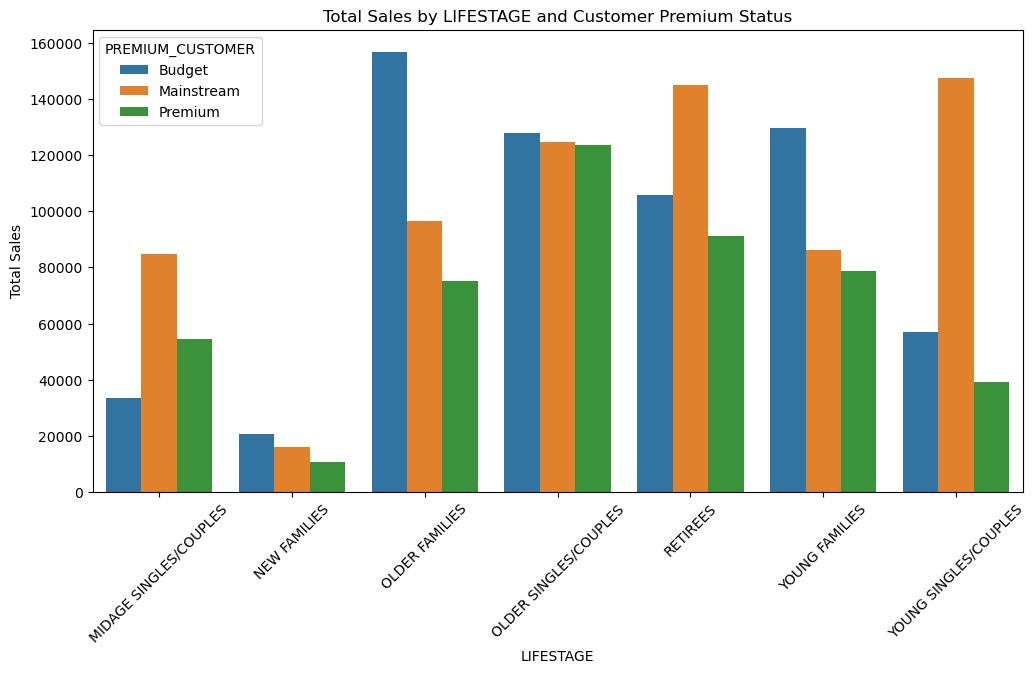

In [37]:
# Plot the total sales by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=sales_by_segment)
plt.xlabel('LIFESTAGE')
plt.ylabel('Total Sales')
plt.title('Total Sales by LIFESTAGE and Customer Premium Status')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Calculate summary statistics of sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].agg(['sum', 'mean', 'count']).reset_index()
sales_summary.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Total_Sales', 'Avg_Sales_per_Customer', 'Num_Customers']
sales_summary


,LIFESTAGE,PREMIUM_CUSTOMER,Total_Sales,Avg_Sales_per_Customer,Num_Customers
0,MIDAGE SINGLES/COUPLES,Budget,33345.70,7.108442,4691
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25,7.637156,11095
2,MIDAGE SINGLES/COUPLES,Premium,54443.85,7.152371,7612
3,NEW FAMILIES,Budget,20607.45,7.297256,2824
4,NEW FAMILIES,Mainstream,15979.70,7.313364,2185
5,NEW FAMILIES,Premium,10760.80,7.231720,1488
6,OLDER FAMILIES,Budget,156863.75,7.291241,21514
7,OLDER FAMILIES,Mainstream,96413.55,7.281440,13241
8,OLDER FAMILIES,Premium,75242.60,7.232779,10403
9,OLDER SINGLES/COUPLES,Budget,127833.60,7.444305,17172


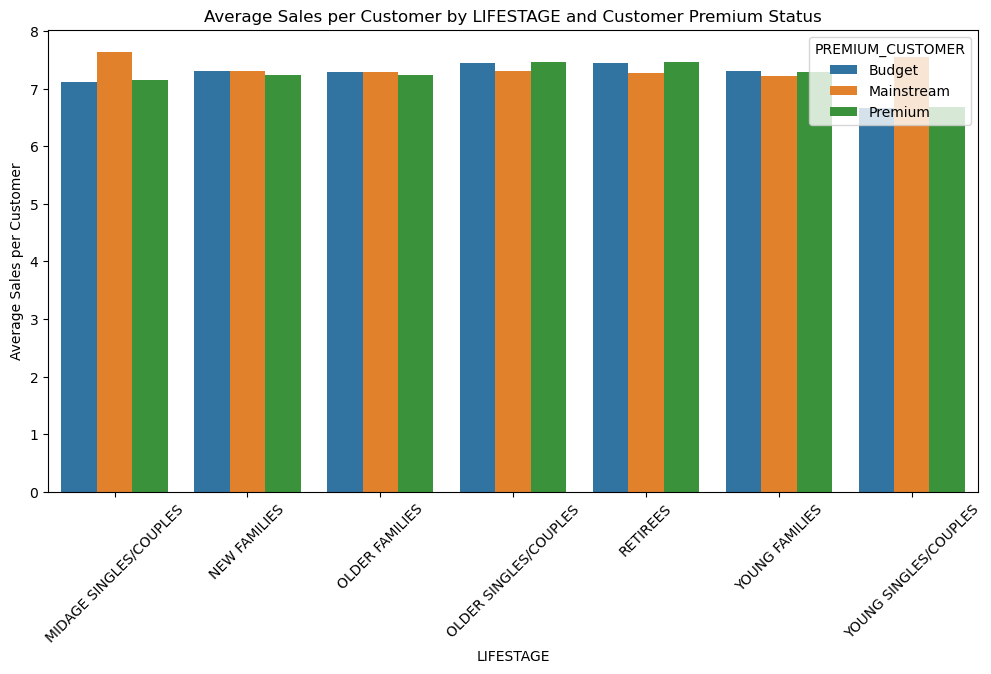

In [39]:
# Plot the average sales per customer by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='Avg_Sales_per_Customer', hue='PREMIUM_CUSTOMER', data=sales_summary)
plt.xlabel('LIFESTAGE')
plt.ylabel('Average Sales per Customer')
plt.title('Average Sales per Customer by LIFESTAGE and Customer Premium Status')
plt.xticks(rotation=45)
plt.show()

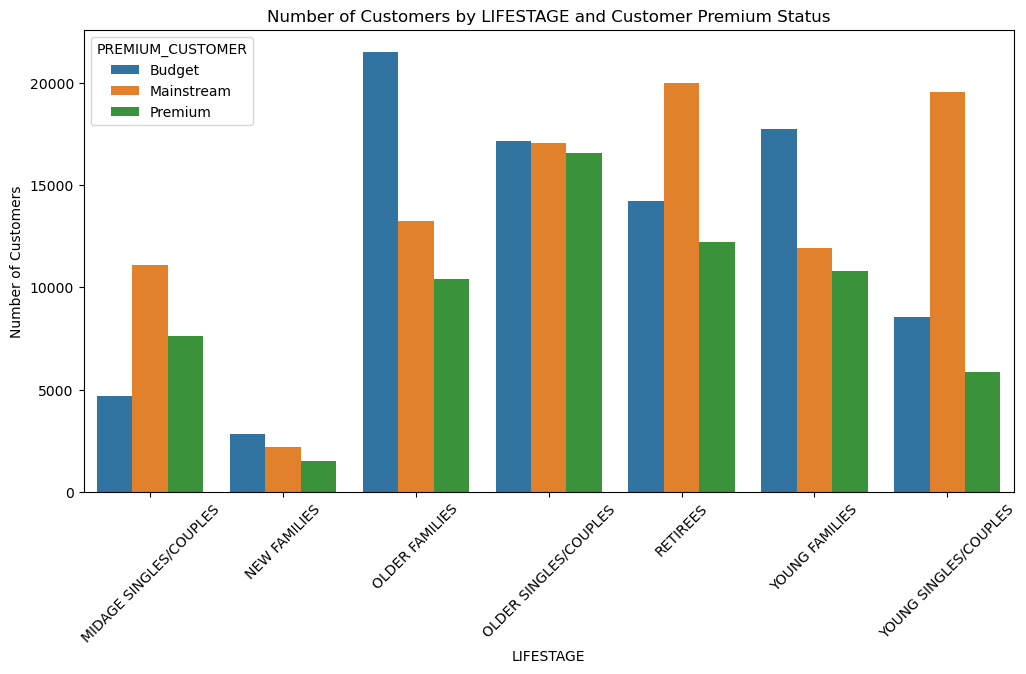

In [40]:

# Plot the number of customers by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='Num_Customers', hue='PREMIUM_CUSTOMER', data=sales_summary)
plt.xlabel('LIFESTAGE')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by LIFESTAGE and Customer Premium Status')
plt.xticks(rotation=45)
plt.show()

In [41]:
# Calculate average number of units per customer
units_by_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()
units_by_segment = units_by_segment.merge(sales_summary[['LIFESTAGE', 'PREMIUM_CUSTOMER', 'Num_Customers']], on=['LIFESTAGE', 'PREMIUM_CUSTOMER'], how='left')
units_by_segment['Avg_Units_per_Customer'] = units_by_segment['PROD_QTY'] / units_by_segment['Num_Customers']
units_by_segment

,LIFESTAGE,PREMIUM_CUSTOMER,PROD_QTY,Num_Customers,Avg_Units_per_Customer
0,MIDAGE SINGLES/COUPLES,Budget,8883,4691,1.893626
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,11095,1.911942
2,MIDAGE SINGLES/COUPLES,Premium,14400,7612,1.891750
3,NEW FAMILIES,Budget,5241,2824,1.855878
4,NEW FAMILIES,Mainstream,4060,2185,1.858124
5,NEW FAMILIES,Premium,2769,1488,1.860887
6,OLDER FAMILIES,Budget,41853,21514,1.945384
7,OLDER FAMILIES,Mainstream,25804,13241,1.948795
8,OLDER FAMILIES,Premium,20239,10403,1.945496
9,OLDER SINGLES/COUPLES,Budget,32883,17172,1.914920


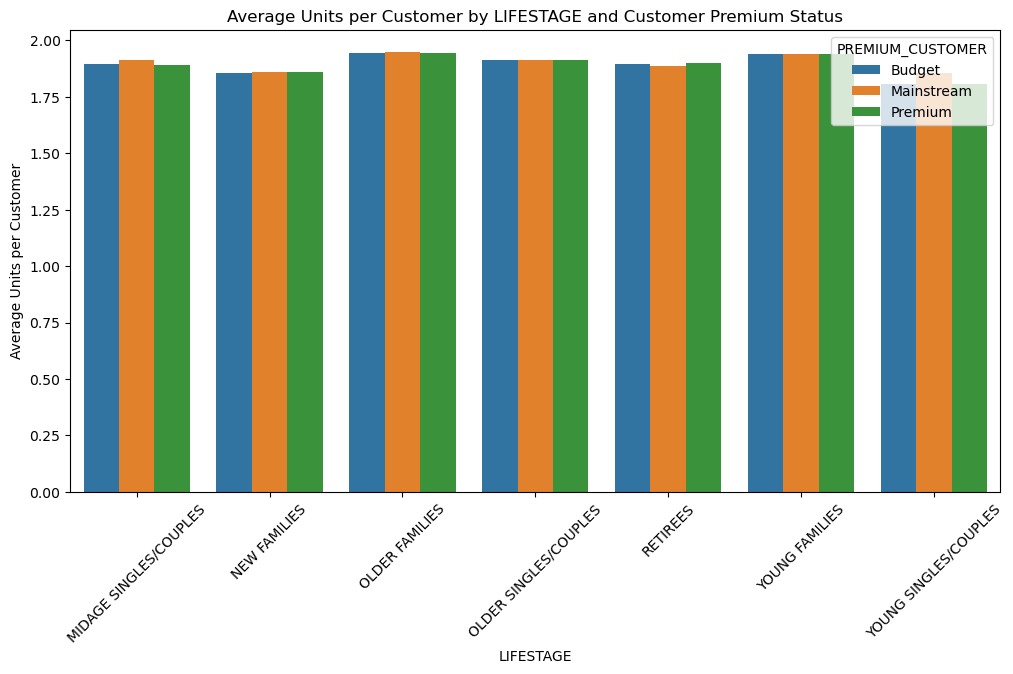

In [42]:
# Plot the average number of units per customer
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='Avg_Units_per_Customer', hue='PREMIUM_CUSTOMER', data=units_by_segment)
plt.xlabel('LIFESTAGE')
plt.ylabel('Average Units per Customer')
plt.title('Average Units per Customer by LIFESTAGE and Customer Premium Status')
plt.xticks(rotation=45)
plt.show()

In [43]:

# Calculate average price per unit
data['Avg_Price_per_Unit'] = data['TOT_SALES'] / data['PROD_QTY']

# Filter data for Midage and Young Singles/Couples
midage_young_singles = data[(data['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')]

# Perform independent t-test 
mainstream_midage_young = midage_young_singles[midage_young_singles['PREMIUM_CUSTOMER'] == 'Mainstream']
premium_budget_midage_young = midage_young_singles[midage_young_singles['PREMIUM_CUSTOMER'].isin(['Premium', 'Budget'])]

t_stat, p_value = stats.ttest_ind(mainstream_midage_young['Avg_Price_per_Unit'], 
                                premium_budget_midage_young['Avg_Price_per_Unit'])

print(f"T-statistic: {t_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The difference in average price per unit between Mainstream and Premium/Budget Midage Singles/Couples is statistically significant.")
else:
    print("The difference in average price per unit between Mainstream and Premium/Budget Midage Singles/Couples is not statistically significant.")

T-statistic: 16.814983102714304
p-value: 4.4499299588142955e-63
The difference in average price per unit between Mainstream and Premium/Budget Midage Singles/Couples is statistically significant.


In [44]:
# Filter for Mainstream - Young Singles/Couples
mainstream_young_singles = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

In [45]:

# Calculate brand purchase frequency
brand_purchase_freq = mainstream_young_singles.groupby('BRAND')['PROD_QTY'].sum().reset_index()
brand_purchase_freq = brand_purchase_freq.sort_values(by='PROD_QTY', ascending=False)
brand_purchase_freq

,BRAND,PROD_QTY
12,Kettle,7172
15,Pringles,4326
6,Doritos,3878
19,Smiths,3252
22,Thins,2187
10,Infuzions,1802
24,Twisties,1673
23,Tostitos,1645
4,Cobs,1617
16,RRD,1160


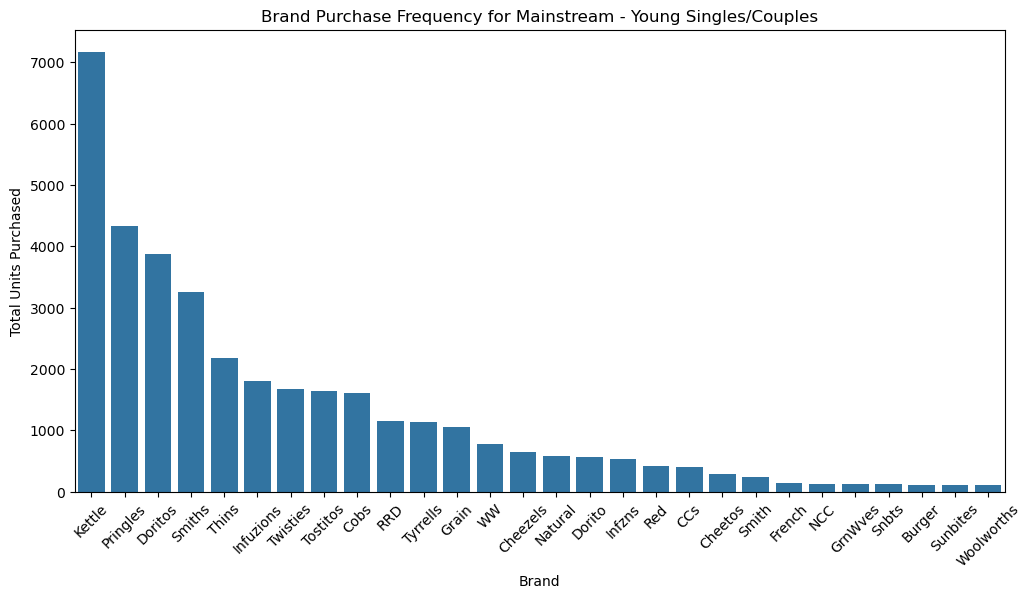

In [46]:
# Plot brand purchase frequency
plt.figure(figsize=(12, 6))
sns.barplot(x='BRAND', y='PROD_QTY', data=brand_purchase_freq)
plt.xlabel('Brand')
plt.ylabel('Total Units Purchased')
plt.title('Brand Purchase Frequency for Mainstream - Young Singles/Couples')
plt.xticks(rotation=45)
plt.show()

In [47]:
# Filter for other customer segments
other_segments = data[~((data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream'))]

In [48]:
# Calculate pack size distribution for Mainstream - Young Singles/Couples
pack_size_dist_target = mainstream_young_singles['PACK_SIZE'].value_counts().reset_index()
pack_size_dist_target.columns = ['PACK_SIZE', 'Frequency_Target']

In [49]:
# Calculate pack size distribution for other segments
pack_size_dist_other = other_segments['PACK_SIZE'].value_counts().reset_index()
pack_size_dist_other.columns = ['PACK_SIZE', 'Frequency_Other']

In [50]:
# Merge the two distributions
pack_size_comparison = pd.merge(pack_size_dist_target, pack_size_dist_other, on='PACK_SIZE', how='outer')
pack_size_comparison.fillna(0, inplace=True)

In [51]:
# Calculate relative frequency (percentage)
pack_size_comparison['Relative_Frequency_Target'] = (pack_size_comparison['Frequency_Target'] / pack_size_comparison['Frequency_Target'].sum()) * 100
pack_size_comparison['Relative_Frequency_Other'] = (pack_size_comparison['Frequency_Other'] / pack_size_comparison['Frequency_Other'].sum()) * 100

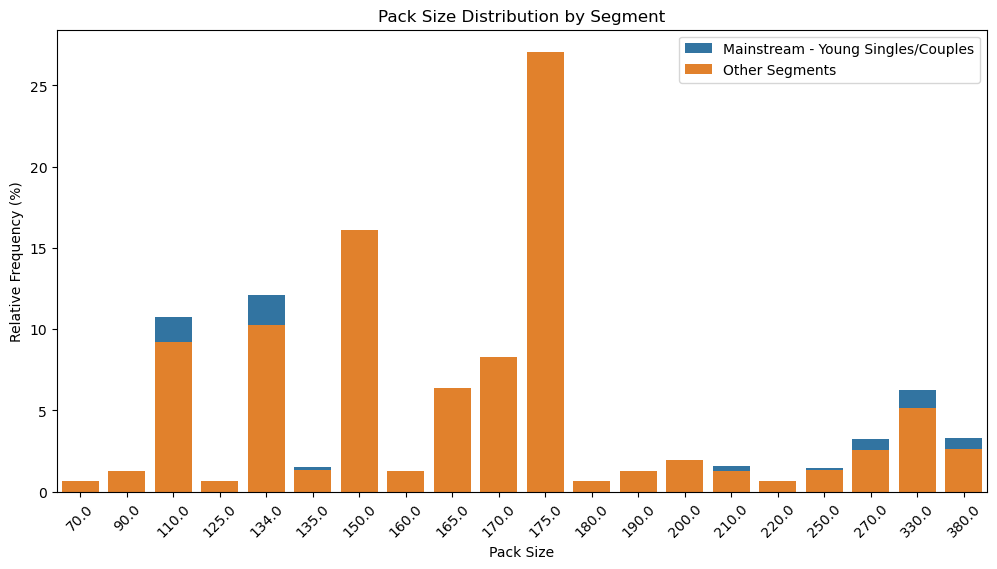

In [52]:
# Plot pack size distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='PACK_SIZE', y='Relative_Frequency_Target', data=pack_size_comparison, label='Mainstream - Young Singles/Couples')
sns.barplot(x='PACK_SIZE', y='Relative_Frequency_Other', data=pack_size_comparison, label='Other Segments')
plt.xlabel('Pack Size')
plt.ylabel('Relative Frequency (%)')
plt.title('Pack Size Distribution by Segment')
plt.legend()
plt.xticks(rotation=45)
plt.show()